# CORRELACIÓN DE ARG Y MGE
El objetivo de este script es encontrar las correlaciones entre MGE y ARG a distintos niveles; así como representarla (un heatmap debiera bastar para ello).

Para estudiar la correlación necesito _toda_ la información, no sólo la presencia única de una amplificación: me interesa también considerar los casos en los que no haya amplificado nada (en el análisis de expresión diferencial optamos por no considerar los no amplificados de ninguna manera, aquí es inevitable). Por tanto, trabajaré con "ab_data_all.csv" 

---
Empiezo buscando correlaciones entre ARG y MGE **que hayan sido detectados** y al nivel más general posible: **plásticos vs control**

In [95]:
import pandas as pd
from scipy import stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np

In [96]:
all_data = pd.read_csv("../data/clean_data/ab_data_all.csv", index_col = 0)
all_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)]
all_data.drop(columns = ["rel_n", "rel_16", "Ct"], inplace = True)
all_data

,Assay,antib,sample,lake,type_f,type_g,or_seq,rel_ab,log_n
0,aacC2,Aminoglycoside,17.0,ion,PUR,plastic,arg,NaN,NaN
1,aacA/aphD,Aminoglycoside,17.0,ion,PUR,plastic,arg,NaN,NaN
2,aac(6')-II,Aminoglycoside,17.0,ion,PUR,plastic,arg,NaN,NaN
3,aphA3,Aminoglycoside,17.0,ion,PUR,plastic,arg,NaN,NaN
4,sat4,Aminoglycoside,17.0,ion,PUR,plastic,arg,NaN,NaN
...,...,...,...,...,...,...,...,...,...
377,dfrAB4,Trimethoprim,14.0,ion,water,control,arg,NaN,NaN
378,dfrC,Trimethoprim,14.0,ion,water,control,arg,NaN,NaN
379,dfrG,Trimethoprim,14.0,ion,water,control,arg,NaN,NaN
380,dfrK,Trimethoprim,14.0,ion,water,control,arg,NaN,NaN


Primer paso, quedarme con aquellas secuencias que hayan amplificado aunque sea sólo en 1 muestra de todas las que aparecen.

In [97]:
# función muy tonta con el objetivo de tomar un df con valores de la variable col1, repetida n veces, 
# que pueden estar presentes (>0) o ausentes (=0). Busca quedarse con aquellos con mínimo un positivo
# en col1 y filtrar el df original para que esto sea cierto
def get_hits(df, col1_name, col2_name):
    hits = df.groupby(by = col1_name).sum() #sólo serán >0 aquellos que amplifiquen
    hits = list(hits[(hits[col2_name] != 0)].index) #coge los positivos, saca la lista de ellos (= el índice)
    df = df.loc[(df[col1_name].isin(hits))]
    return df

In [98]:
print(all_data.shape[0]) #para chequear si funciona o no
work_data = get_hits(all_data, "Assay", "rel_ab") 
print(work_data.shape[0]) #para chequear si funciona o no

del all_data
work_data.reset_index(inplace = True, drop = True) #si el index está descolocado da problemas
work_data
#work_data.loc[(work_data["Assay"] == "trb-C") & (work_data["type_g"] == "plastic")]

6858
1062


,Assay,antib,sample,lake,type_f,type_g,or_seq,rel_ab,log_n
0,aac3ia,Aminoglycoside,17.0,ion,PUR,plastic,arg,0.000166,-3.780
1,aph4ib,Aminoglycoside,17.0,ion,PUR,plastic,arg,0.000545,-3.264
2,aph6ic,Aminoglycoside,17.0,ion,PUR,plastic,arg,0.000192,-3.717
3,spcN,Aminoglycoside,17.0,ion,PUR,plastic,arg,NaN,NaN
4,aadA6,Aminoglycoside,17.0,ion,PUR,plastic,arg,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1057,IS21-ISAs29,MGE,14.0,ion,water,control,mge,NaN,NaN
1058,IS91,MGE,14.0,ion,water,control,mge,NaN,NaN
1059,trb-C,Plasmid,14.0,ion,water,control,mge,0.000385,-3.414
1060,IncP_oriT,Plasmid-inc,14.0,ion,water,control,mge,NaN,NaN


Ahora voy a crear un df gigantesco, pues voy a emparejar cada MGE que haya amplificado en cada uno de los 18 casos con cada ARG de los 18 casos. En teoría, después debiera bastar con ir filtrando este df para conseguir lo que queremos a cualquier nivel

Para enteder qué está sucediendo basta con mirar "Assay_x" (+ "or_seq_x") y "Assay_y"(+ "or_seq_y"): cada secuencia individual de mge se ha emparejado con cada secuencia individual de arg.

Una vez tengo TODOS los emparejamientos posibles, empiezo a filtrar a distintos niveles para ir respondiendo a las preguntas de correlación a cada nivel de interés. Empecemos por el más general: **¿hay diferencias en la correlación existente entre MGE y ARG en las muestras de plástico vs las muestras control?**

Antes de nada, aclarar: voy a buscar correlación de presencia/ausencia. El estudio de correlación basado en la cantidad no lo terminé de comprender, asi que por ahora lo dejo aparcado. Eso significa que puedo alterar los valores de rel_ab sin que afecte al resultado final (fundamentalmente, voy a sustituir los NaN por 0s)

In [99]:
work_data.fillna(value = 0, inplace = True)
work_data.head()

/tmp/ipykernel_3793/1547826441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_data.fillna(value = 0, inplace = True)


,Assay,antib,sample,lake,type_f,type_g,or_seq,rel_ab,log_n
0,aac3ia,Aminoglycoside,17.0,ion,PUR,plastic,arg,0.000166,-3.780
1,aph4ib,Aminoglycoside,17.0,ion,PUR,plastic,arg,0.000545,-3.264
2,aph6ic,Aminoglycoside,17.0,ion,PUR,plastic,arg,0.000192,-3.717
3,spcN,Aminoglycoside,17.0,ion,PUR,plastic,arg,0.000000,0.000
4,aadA6,Aminoglycoside,17.0,ion,PUR,plastic,arg,0.000000,0.000


In [6]:
def corr_presence (x, y, merge_col_name = "sample", groupby_name = "Assay", presence_col = "rel_ab", threshold = 0, how = "pos"):
    """
    Esta función correlaciona la presencia de MGE con ARG para los grupos dados. Para ello, toma datos del
    df original y pide que se diferencie entre el grupo "x" e "y" que se quieren correlacionar entre sí. Para
    ello, primero empareja los datos y luego los divide en grupos de parejas, que serán los que se estudien para 
    computar la correlación.
    
    Es necesario aportar: 
    - El nombre de la columna en el cual se quiere hacer el merge (que será aquello que se quiera enfrentar 
    entre sí, "merge_col_name", que por comodidad de base = sample). Mergear sirve para EMPAREJAR.
    - El nombre de la columna que quiere emplearse para agrupar. Agrupar sirve para ESTUDIAR CADA PAREJA POR SEPARADO
    - El nombre de la columna cuyo valor refleja la presencia/ausencia 
    
    Opcionalmente, permite especificar un mínimo por el cual ignorará resultados inferiores a él, así como si
    se quiere conservar las correlaciones negativas o no (how = pos conservará sólo correlaciones positivas, = neg
    mantendrá todas
    """
    # Cambia el nombre de las columnas
    
    # Lleva a cabo el merge original, el emparejamiento
    merged_df = pd.merge(x, y, on = merge_col_name)
    
    # Genera los nuevos nombres de variable
    group_x = groupby_name + "_x"
    group_y = groupby_name + "_y"
    presence_col_x = presence_col + "_x"
    presence_col_y = presence_col + "_y"
    
    grouped_merge = merged_df.groupby([group_x, group_y])
    
    corr_dict ={}
    for name, group in grouped_merge:
        # primero ajusto valores a presencia/ausencia
        group.loc[(group[presence_col_x] > 0), presence_col_x] = 1 #si amplifica, presente (=1) en esa muestra
        group.loc[(group[presence_col_y] > 0), presence_col_y] = 1 # 3/4 de lo mismo con ARG
        
        # si en esa muestra ambos están presentes, su probabilidad de coexistir es del 100% (=1)
        group.loc[(group[presence_col_x] == 1) & (group[presence_col_y] == 1), "ocurrence"] = 1  
        # si en esa muestra ambos faltan, NO PODEMOS DECIR NADA DE SU POSIBILIDAD DE COEXISTIR (=?)
        # si uno (MGE) está presente y el otro (ARG) no, su posibilidad de coexistir es 0% (=0)
        group.loc[((group[presence_col_x] == 1) & (group[presence_col_y] == 0) | (group[presence_col_x] == 0) & (group[presence_col_y] == 1)), "ocurrence"] = 0
        # y OJO AQUÍ: si uno (MGE) falta pero el otro está presente (ARG), el segundo REPELE al primero (= -1)
        #group.loc[(group[presence_col_x] == 0) & (group[presence_col_y] == 1), "ocurrence"] = -1
    
        
        
        #Por último, computa la media de posibilidades y filtra en base a un valor arbitrario (pongo >60%)
        corr_res = group["ocurrence"].mean()
        if how == "pos":
            if corr_res >= threshold: corr_dict[name] = [corr_res] #el valor se guarda como lista para facilitar pasar de dict a df
        if how == "neg":
            if abs(corr_res) >= threshold: corr_dict[name] = [corr_res]
    
    return corr_dict

In [7]:
def dict_pivotizer(results_dict, copy = False,
                  id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                  id1_fam = "MGE_family", id2_fam = "ARG_family"):
    """
    Esta función lo que hace es automatizar un montón de pasos que sigo para pasar de los diccionarios con resultados de correlación originales
    generados por las distintas funciones a la pivot table final que seaborn sabe interpretar. Esta hardcodeado a lo bestia y probablemente
    no pueda reusarlo en otros contextos, pero por cuestiones de limpieza es mejor que declare esto una vez y me olvide de aquí en adelante
    
    - results_dict: el diccionario que contiene los resultados que se quieren representar
    - copy: por si se quisiera sacar una copia de los resultados y así evitar recalcular
    - id1_name: nombre de la primera variable correlacionada, LA QUE SE REPRESENTA EN HORIZONTAL, LOS NOMBRES DE LAS COLUMNAS
    - id2_name: nombre de la segunda variable correlacionada, LA QUE SE REPRESENTA EN VERTICAL, LOS NOMBRES DE LAS FILAS
    - id1_fam: nombre de la agrupación de la variable 1. Sirve para ordenar la pivot final agrupando datos
    - id2_fam: nombre de la agrupación de la variable 2. Sirve para ordenar la pivot final agrupando datos
    - val_name: nombre que de los valores que se están representando
    """
    #coge el diccionario original y lo pasa a df
    corr_df = pd.DataFrame(results_dict)
    corr_df = corr_df.T
    corr_df.index.set_names([id1_name, id2_name], inplace = True) #en ese orden salen los resultados
    corr_df.rename(columns = {0: val_name}, inplace = True)
    corr_df.reset_index(inplace = True)
    if copy == True: #en aquellos casos que me interesa generar una copia en archivo del csv, este es el mejor momento
        print("Copying! REMEMBER TO CHANGE THE NAME!!")
        corr_df.to_csv("../data/clean_data/quick_copy.csv")
    
    # Este paso de aquí sirve para conseguir la información de familias de ARG/MGE 
    fam_fix = work_data[["Assay", "antib"]]
    fam_fix = fam_fix.drop_duplicates(subset = ["Assay"]) 
    fam_fix.rename(columns = {"Assay": id2_name}, inplace = True) #llama "ARG" A TODO, INCLUYENDO MGE
    #junta los resultados con su familia de antibiótico
    corr_df = pd.merge(left = corr_df, right = fam_fix, #OJO, sólo se va a quedar con los ARG, ningún MGE queda asignado
                       on = id2_name, how = "inner")
    corr_df.rename(columns = {"antib": id2_fam}, inplace = True) #esto le pone un nombre lógico a la columna
    # ugly hack que asigna los MGE sin duplicar nada
    fam_fix.rename(columns = {"ARG": id1_name}, inplace = True)
    corr_df = pd.merge(left = corr_df, right = fam_fix,
                   on = id1_name, how = "inner")
    corr_df.rename(columns = {"antib": id1_fam}, inplace = True)
    #genera la pivot final. Ojo que está multiindexada
    final_pivot = pd.pivot_table(data = corr_df,
                                 values = val_name,
                                 columns = [id1_fam, id1_name],
                                 index = [id2_fam, id2_name])
    return final_pivot

## ANÁLISIS DESCRIPTIVO DE LA CORRELACIÓN
Ver cuándo coinciden unos con otros, simple y llanamente. No considero ningún tipo de penalización.

---

### PLÁSTICO VS CONTROL
#### PLÁSTICO

In [8]:
corr_data = corr_presence(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "plastic")],
                     y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "plastic")],
                     merge_col_name = "sample",
                     groupby_name = "Assay",
                     presence_col = "rel_ab",
                     threshold = 0,
                     how = "neg"
                    )
#corr_data

Llegados a este punto ya tengo los resultados de correlación, lo que me falta es representarlo. Procedo con el caso de un heatmap

Que se dice pronto, porque para pasar de ese diccionario a datos en formato pivot table hay que recorrer un muy largo camino. **La función dict_pivotizer hace exactamente eso, pero me viene bien tenerla aquí detallada para poder visualizar qué sucede en cada paso**

In [9]:
corr_df = pd.DataFrame(corr_data)
corr_df

IS21-ISAs29                                                             ...  \
        QnrB4 VanB aac3-Via aac3ia aadA16 aadA17 aadA6 acrF acrR ant6-ib  ...   
0         0.0  1.0      0.1    0.0    0.0    0.5   0.0  0.0  0.0     1.0  ...   

   trb-C                                                             
    mphA   oleC oprD qepA_1_2 spcN    tetG_F tetL tetPA  vanA vanHB  
0  0.125  0.125  0.4      0.0  0.2  0.444444  0.0   0.2  0.25  0.25  

[1 rows x 562 columns]

In [10]:
corr_df = corr_df.T
corr_df.head()

0
IS21-ISAs29 QnrB4     0.0
            VanB      1.0
            aac3-Via  0.1
            aac3ia    0.0
            aadA16    0.0

In [11]:
corr_df.index.set_names(["MGE", "ARG"], inplace = True)
corr_df.rename(columns = {0: "correlation"}, inplace = True)
corr_df.tail()

correlation
MGE   ARG                
trb-C tetG_F     0.444444
      tetL       0.000000
      tetPA      0.200000
      vanA       0.250000
      vanHB      0.250000

In [12]:
corr_df.reset_index(inplace = True)
corr_df.head()

,MGE,ARG,correlation
0,IS21-ISAs29,QnrB4,0.0
1,IS21-ISAs29,VanB,1.0
2,IS21-ISAs29,aac3-Via,0.1
3,IS21-ISAs29,aac3ia,0.0
4,IS21-ISAs29,aadA16,0.0


Llegados a este punto ya podría pasar a formato pivot table y hacer los df, pero antes me interesa ver si puedo recuperar la información sobre las familias de antibióticos/tipo de MGE, para ver si así se pudieran ver patrones a nivel de familia. Asi que vuelvo a rescatar esa info, que la tengo en work_data

In [13]:
fam_fix = work_data[["Assay", "antib"]]
fam_fix = fam_fix.drop_duplicates(subset = ["Assay"]) #recordemos que work_data tiene, por diseño, infinidad de repetidos

# Antes de hacer el merge cambio el nombre de la columna Assay a ARG: asi puedo hacer un merge, y siendo inner left
# no cogerá información de los MGE. Luego toca repetir con los MGE lo mismo
fam_fix.rename(columns = {"Assay": "ARG"}, inplace = True)
corr_df = pd.merge(left = corr_df, right = fam_fix,
                   on = "ARG", how = "inner")
corr_df.rename(columns = {"antib": "ARG_family"}, inplace = True)

fam_fix.rename(columns = {"ARG": "MGE"}, inplace = True)
corr_df = pd.merge(left = corr_df, right = fam_fix,
                   on = "MGE", how = "inner")
corr_df.rename(columns = {"antib": "MGE_family"}, inplace = True)

corr_df

,MGE,ARG,correlation,ARG_family,MGE_family
0,IS21-ISAs29,QnrB4,0.000000,Fluoroquinolone,MGE
1,IS21-ISAs29,VanB,1.000000,Vancomycin,MGE
2,IS21-ISAs29,aac3-Via,0.100000,Aminoglycoside,MGE
3,IS21-ISAs29,aac3ia,0.000000,Aminoglycoside,MGE
4,IS21-ISAs29,aadA16,0.000000,Aminoglycoside,MGE
...,...,...,...,...,...
557,trb-C,tetG_F,0.444444,Tetracycline,Plasmid
558,trb-C,tetL,0.000000,Tetracycline,Plasmid
559,trb-C,tetPA,0.200000,Tetracycline,Plasmid
560,trb-C,vanA,0.250000,Vancomycin,Plasmid


Y ya debiera poder hacer la pivot table

In [14]:
plastic_pivot = pd.pivot_table(data = corr_df,
                         values = "correlation",
                         columns = ["MGE_family", "MGE"],
                         index = ["ARG_family", "ARG"])
plastic_pivot.tail()

MGE_family          Insertional                                      \
MGE                ISPps1-pseud ISSm2-Xanthob orf37-IS26 orf39-IS26   
ARG_family   ARG                                                      
Tetracycline tetL           0.0           0.0       1.00        0.0   
             tetPA          0.0           0.0       0.25        0.0   
Vancomycin   VanB           0.0           0.0       0.00        0.0   
             vanA           0.0           0.0       0.00        0.0   
             vanHB          0.0           0.0       0.00        0.0   

MGE_family                  Integrase               MGE                   \
MGE                intI1F165_clinical intl3 IS21-ISAs29      IS91 TN5403   
ARG_family   ARG                                                           
Tetracycline tetL            0.142857   0.1         0.0  0.000000    0.0   
             tetPA           0.571429   0.4         0.0  0.000000    0.0   
Vancomycin   VanB            0.000000   0.1         1.0  0.333333    1.0   
             vanA            0.125000   0.2         0.0  0.250000    0.0   
             vanHB           0.000000   0.2         0.5  0.666667    0.5   

MGE_family         Plasmid Plasmid-inc Transposase  
MGE                  trb-C   IncP_oriT       tnpAd  
ARG_family   ARG                                    
Tetracycline tetL    0.000         0.2         0.0  
             tetPA   0.200         0.5         0.0  
Vancomycin   VanB    0.125         0.0         0.0  
             vanA    0.250         0.0         0.0  
             vanHB   0.250         0.0         0.0

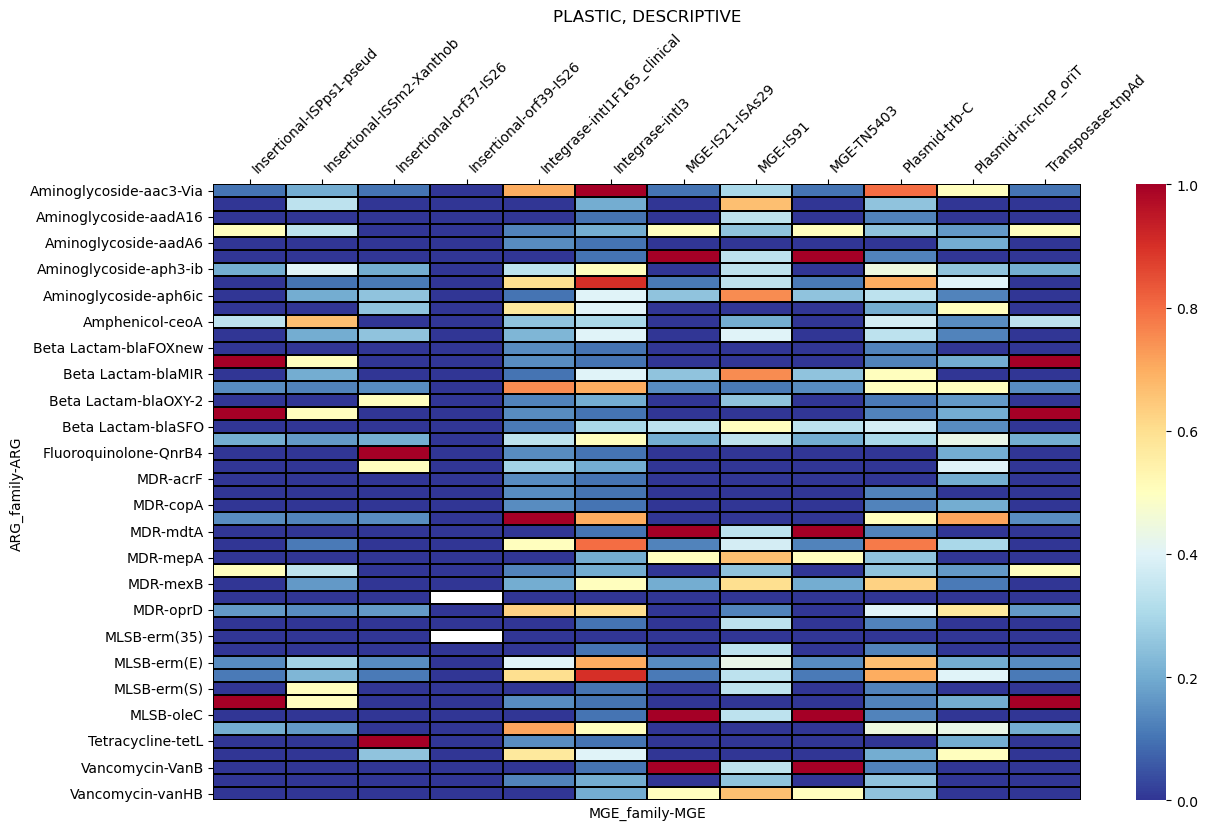

In [54]:
fig, ax = plt.subplots(figsize=(14,8))
red_cmap = mpl.colormaps["RdYlBu_r"]
#red_cmap.set_under("white", alpha = 0.4) #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(plastic_pivot, 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("PLASTIC, DESCRIPTIVE")
ax.xaxis.tick_top()

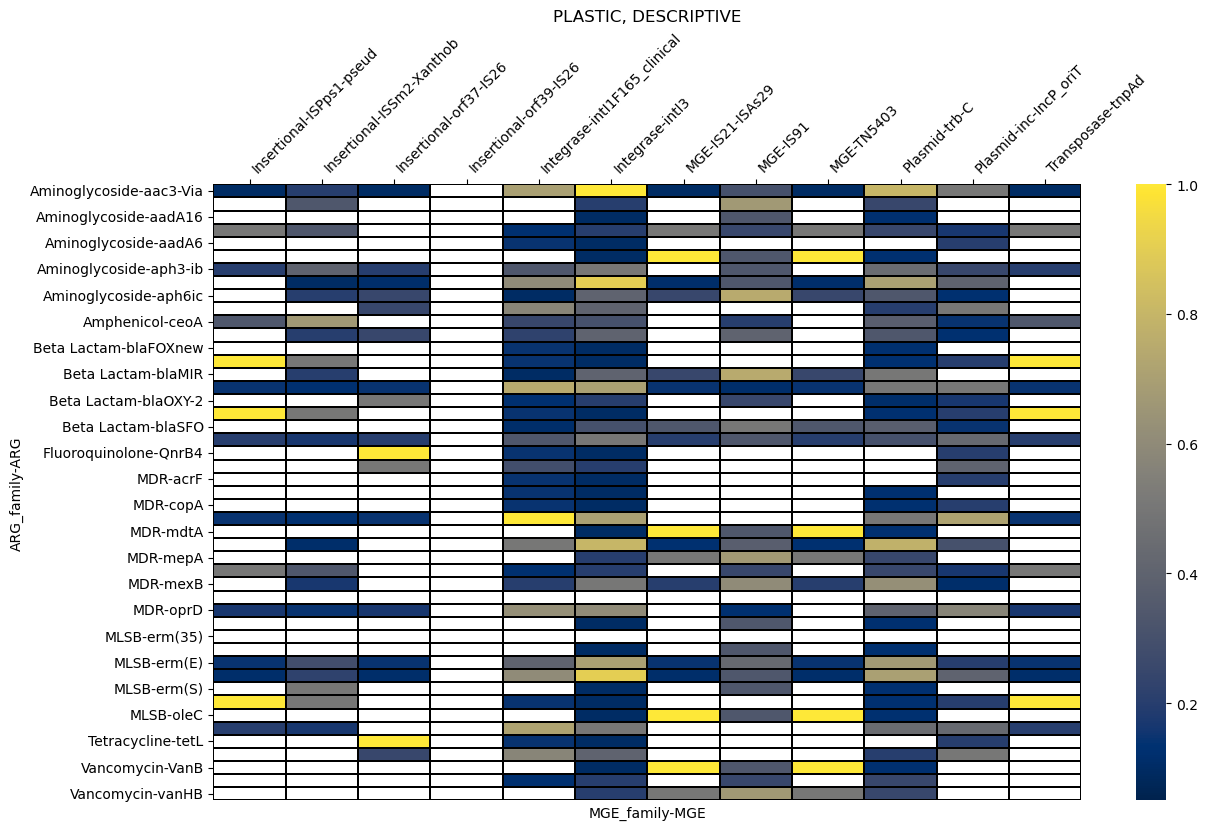

In [55]:
### ALTERNATIVA
fig, ax = plt.subplots(figsize=(14,8))
red_cmap = mpl.colormaps["cividis"]
red_cmap.set_under("white") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(plastic_pivot, 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0.05,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("PLASTIC, DESCRIPTIVE")
ax.xaxis.tick_top()

#### CONTROL

In [17]:
# Todo el procesado de datos de golpe, pues ya sé que funciona
corr_data = corr_presence(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "control")],
                     y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "control")],
                     merge_col_name = "sample",
                     groupby_name = "Assay",
                     presence_col = "rel_ab",
                     threshold = 0,
                     how = "neg"
                    )
control_pivot = dict_pivotizer(corr_data, copy = False,
                               id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                               id1_fam = "MGE_family", id2_fam = "ARG_family")
control_pivot.head()

MGE_family               Insertional                                      \
MGE                     ISPps1-pseud ISSm2-Xanthob orf37-IS26 orf39-IS26   
ARG_family     ARG                                                         
Aminoglycoside aac3-Via          0.0           0.0        0.4        0.2   
               aac3ia            NaN           NaN        0.0        0.0   
               aadA16            0.0           0.0        0.5        1.0   
               aadA17            NaN           NaN        0.0        0.0   
               aadA6             NaN           NaN        0.0        0.0   

MGE_family                       Integrase                   MGE              \
MGE                     intI1F165_clinical     intl3 IS21-ISAs29 IS91 TN5403   
ARG_family     ARG                                                             
Aminoglycoside aac3-Via                0.4  0.500000         0.0  0.0    0.0   
               aac3ia                  0.0  0.000000         NaN  NaN    NaN   
               aadA16                  0.0  0.142857         0.0  0.0    0.0   
               aadA17                  0.0  0.000000         NaN  NaN    NaN   
               aadA6                   0.0  0.000000         NaN  NaN    NaN   

MGE_family                Plasmid Plasmid-inc Transposase  
MGE                         trb-C   IncP_oriT       tnpAd  
ARG_family     ARG                                         
Aminoglycoside aac3-Via  0.833333         0.0         0.0  
               aac3ia    0.000000         0.0         NaN  
               aadA16    0.166667         0.0         0.0  
               aadA17    0.000000         0.0         NaN  
               aadA6     0.000000         0.0         NaN

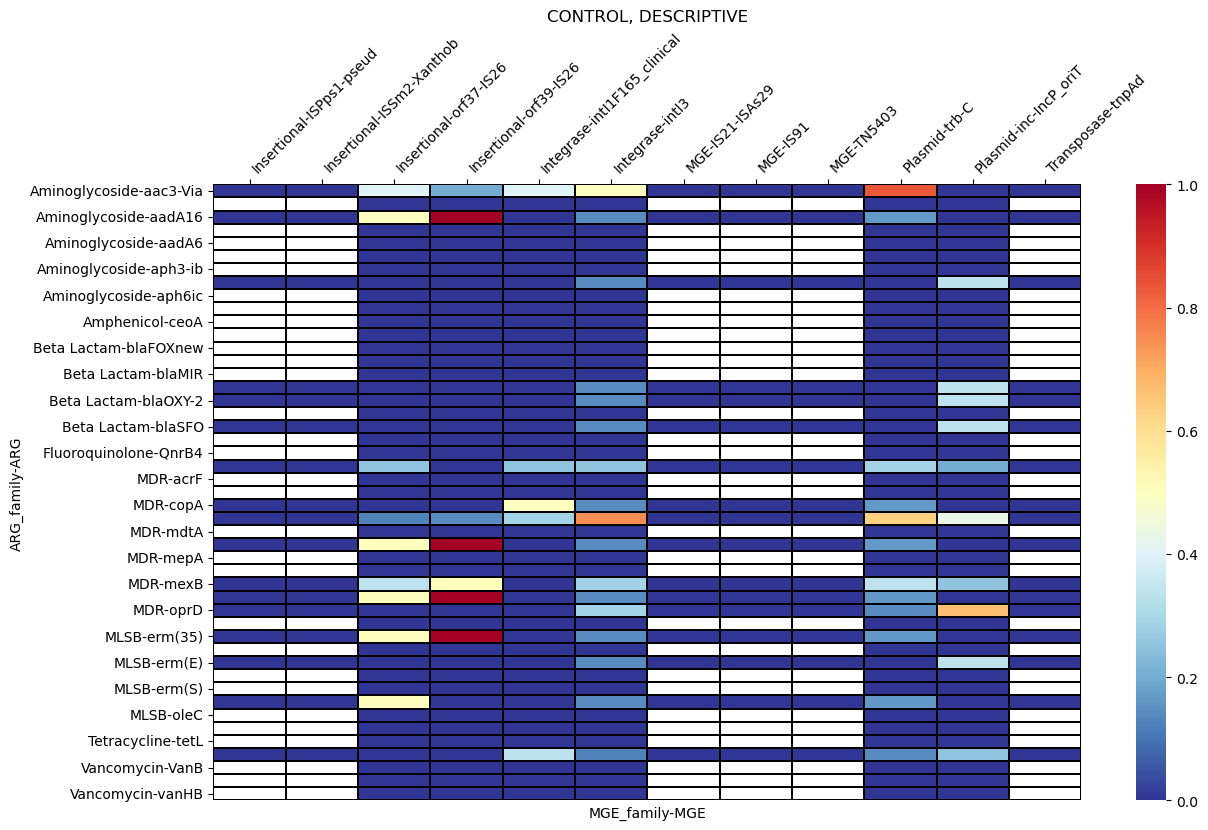

In [56]:
fig, ax = plt.subplots(figsize=(14,8))
red_cmap = mpl.colormaps["RdYlBu_r"]
#red_cmap.set_under("white", alpha = 0.4) #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(control_pivot, 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("CONTROL, DESCRIPTIVE")
ax.xaxis.tick_top()

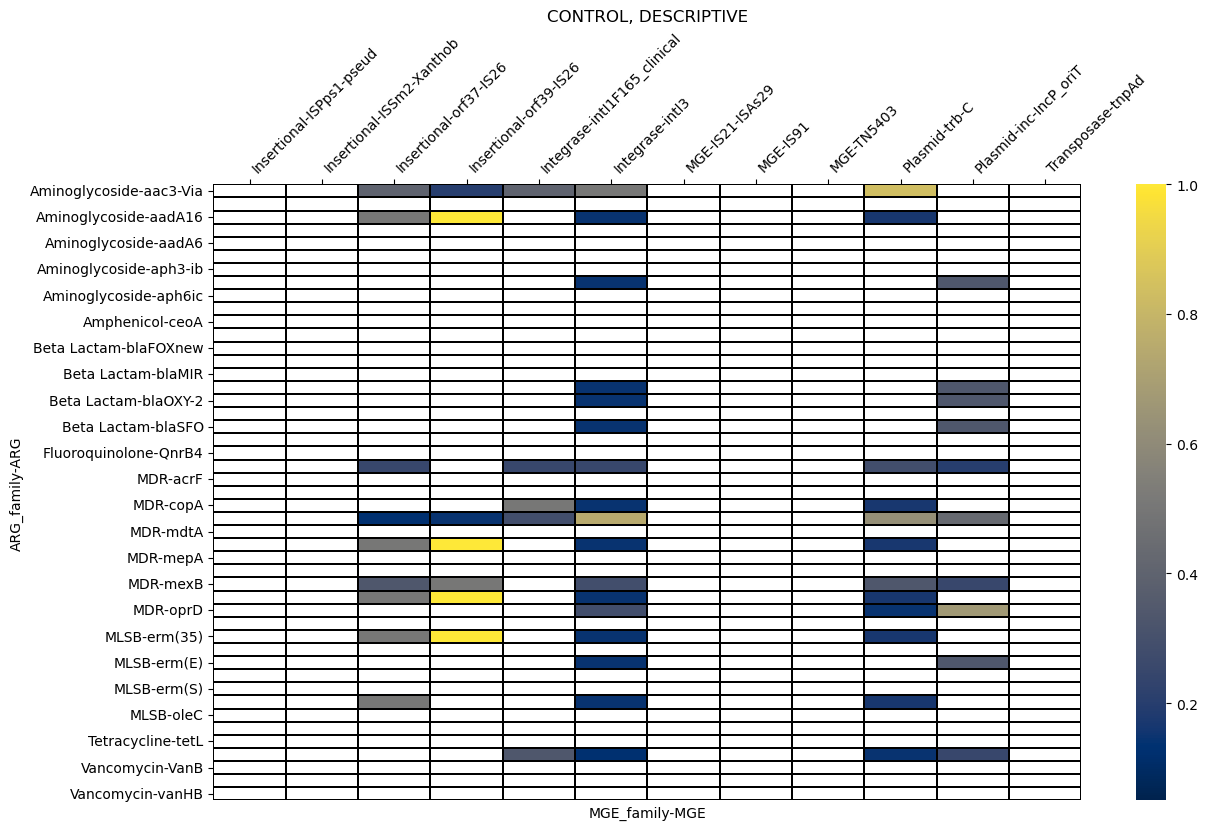

In [57]:
### ALTERNATIVA
fig, ax = plt.subplots(figsize=(14,8))
red_cmap = mpl.colormaps["cividis"]
red_cmap.set_under("white") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(control_pivot, 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0.05,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("CONTROL, DESCRIPTIVE")
ax.xaxis.tick_top()

#### PLÁSTICO VS CONTROL

Voy a probar una visualización de la comparativa entre ambas. No he visto a nadie hacer nada similar ni sé si tiene validez por no realizarse vía comparación estadística (tampoco sé cómo hacer una comparativa estadística cuando n = 1, siempre).

Fundamentalmente, resto los valores de correlación observados en el control a los valores de correlación observados en plásticos. Por tanto, **si el resultado es positivo (ROJO), está más fuertemente correlacionado en plástico. Si es negativo (AZUL), está más fuertemente correlacionado en el control.**

In [20]:
comparision_pivot = plastic_pivot - control_pivot
comparision_pivot.head()

MGE_family               Insertional                                      \
MGE                     ISPps1-pseud ISSm2-Xanthob orf37-IS26 orf39-IS26   
ARG_family     ARG                                                         
Aminoglycoside aac3-Via          0.1           0.2       -0.3       -0.2   
               aac3ia            NaN           NaN        0.0        0.0   
               aadA16            0.0           0.0       -0.5       -1.0   
               aadA17            NaN           NaN        0.0        0.0   
               aadA6             NaN           NaN        0.0        0.0   

MGE_family                       Integrase                   MGE            \
MGE                     intI1F165_clinical     intl3 IS21-ISAs29      IS91   
ARG_family     ARG                                                           
Aminoglycoside aac3-Via           0.300000  0.500000         0.1  0.300000   
               aac3ia             0.000000  0.200000         NaN       NaN   
               aadA16             0.000000 -0.042857         0.0  0.333333   
               aadA17             0.125000  0.200000         NaN       NaN   
               aadA6              0.142857  0.100000         NaN       NaN   

MGE_family                       Plasmid Plasmid-inc Transposase  
MGE                     TN5403     trb-C   IncP_oriT       tnpAd  
ARG_family     ARG                                                
Aminoglycoside aac3-Via    0.1 -0.033333    0.500000         0.1  
               aac3ia      NaN  0.250000    0.000000         NaN  
               aadA16      0.0 -0.041667    0.000000         0.0  
               aadA17      NaN  0.250000    0.166667         NaN  
               aadA6       NaN  0.000000    0.200000         NaN

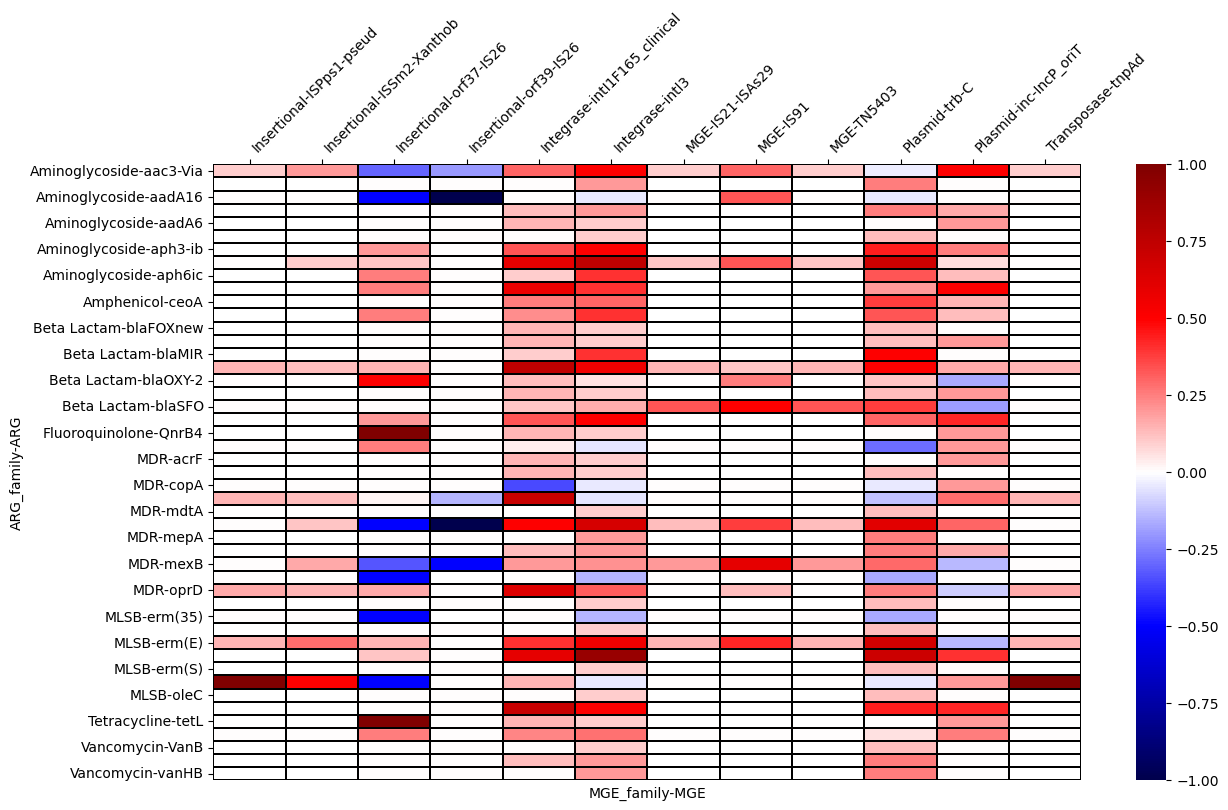

In [58]:
fig, ax = plt.subplots(figsize=(14,8))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_bad("white") 
lala = sns.heatmap(comparision_pivot, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.xaxis.tick_top()

### MGE (PLÁSMIDOS) VS MGE

#### PLÁSTICO 

In [22]:
# Todo el procesado de datos de golpe, pues ya sé que funciona
corr_data = corr_presence(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "plastic")],
                          y = work_data.loc[(work_data["or_seq"] == "mge") & 
                                            (work_data["antib"].isin(["Plasmid", "Plasmid-rep", "Plasmid-inc"])) &
                                            (work_data["type_g"] == "plastic")
                                           ],
                     merge_col_name = "sample",
                     groupby_name = "Assay",
                     presence_col = "rel_ab",
                     threshold = 0,
                     how = "neg")

plasmid_plastic = dict_pivotizer(corr_data, copy = False,
                                 id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                                 id1_fam = "MGE_family", id2_fam = "plasmid_type")
plasmid_plastic.head()

MGE_family              Insertional                                      \
MGE                    ISPps1-pseud ISSm2-Xanthob orf37-IS26 orf39-IS26   
plasmid_type ARG                                                          
Plasmid      trb-C            0.125      0.250000        0.0        0.0   
Plasmid-inc  IncP_oriT        0.200      0.166667        0.2        0.0   

MGE_family                      Integrase               MGE                \
MGE                    intI1F165_clinical intl3 IS21-ISAs29   IS91 TN5403   
plasmid_type ARG                                                            
Plasmid      trb-C               0.500000   0.8       0.125  0.375  0.125   
Plasmid-inc  IncP_oriT           0.714286   0.5       0.000  0.000  0.000   

MGE_family             Plasmid Plasmid-inc Transposase  
MGE                      trb-C   IncP_oriT       tnpAd  
plasmid_type ARG                                        
Plasmid      trb-C         1.0         0.3       0.125  
Plasmid-inc  IncP_oriT     0.3         1.0       0.200

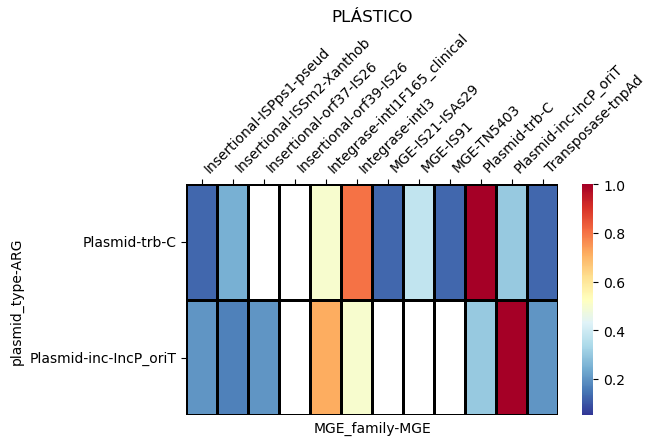

In [23]:
fig, ax = plt.subplots(figsize=(6,3))
red_cmap = mpl.colormaps["RdYlBu_r"]
red_cmap.set_under("white") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(plasmid_plastic, 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0.05,
                   linecolor = "black",
                   linewidths = 1, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title ("PLÁSTICO")
ax.xaxis.tick_top()

#### CONTROL

In [24]:
# Todo el procesado de datos de golpe, pues ya sé que funciona
corr_data = corr_presence(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "control")],
                          y = work_data.loc[(work_data["or_seq"] == "mge") & 
                                            (work_data["antib"].isin(["Plasmid", "Plasmid-rep", "Plasmid-inc"])) &
                                            (work_data["type_g"] == "control")
                                           ],
                          merge_col_name = "sample",
                          groupby_name = "Assay",
                          presence_col = "rel_ab",
                          threshold = 0,
                          how = "neg"
                         )
plasmid_control = dict_pivotizer(corr_data, copy = False,
                                 id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                                 id1_fam = "MGE_family", id2_fam = "plasmid_type")

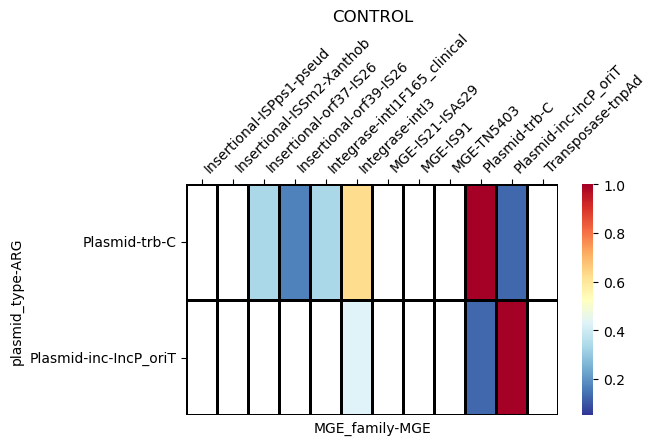

In [25]:

fig, ax = plt.subplots(figsize=(6,3))
red_cmap = mpl.colormaps["RdYlBu_r"]
red_cmap.set_under("white") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(plasmid_control, 
                   cmap = red_cmap,
                   vmax = 1, vmin = 0.05,
                   linecolor = "black",
                   linewidths = 1, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title ("CONTROL")
ax.xaxis.tick_top()

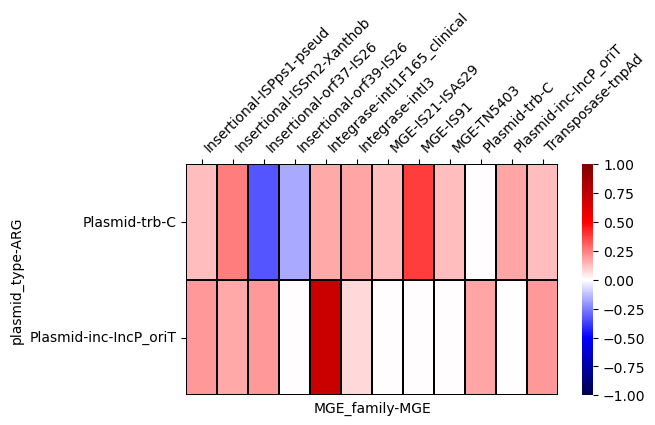

In [26]:
plasmid_comparision = plasmid_plastic - plasmid_control
fig, ax = plt.subplots(figsize=(6,3))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_bad("white") 
lala = sns.heatmap(plasmid_comparision, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.01)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.xaxis.tick_top()

## ANÁLISIS ESTADÍSTICO DE LA CORRELACIÓN

---

### CORRELACIÓN DE SPEARMAN

Misma idea, pero en vez de para describir la situación, sacar conclusiones estadísticas generalizadas

In [27]:
def spearman_finder (x, y, merge_col_name = "sample", 
                     groupby_name = "Assay", test_col = "log_n",
                     p_val = 0.05, threshold = 0):
    
    # Lleva a cabo el merge original, el emparejamiento
    merged_df = pd.merge(x, y, on = merge_col_name)
    
    # Genera los nuevos nombres de variable
    group_x = groupby_name + "_x"
    group_y = groupby_name + "_y"
    test_x = test_col + "_x"
    test_y = test_col + "_y"
    
    grouped_merge = merged_df.groupby([group_x, group_y]) #y empareja
    
    corr_dict ={}
    for name, group in grouped_merge:
        corr_res = stat.spearmanr(group[test_x], group[test_y], nan_policy = "omit")
        if (abs(corr_res[0]) >= threshold) and (corr_res[1] < p_val): corr_dict[name] = corr_res
    return corr_dict

#### PLÁSTICO

In [28]:
corr_data = spearman_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "plastic")],
                            y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "plastic")],
                            merge_col_name = "sample",
                            groupby_name = "Assay",
                            test_col = "rel_ab",
                            threshold = 0,
                            p_val = 0.05
                           )
plastic_spear = dict_pivotizer(corr_data, copy = False,
                               id1_name = "MGE", id2_name = "ARG", val_name = "correlation",
                               id1_fam = "MGE_family", id2_fam = "ARG_family")
plastic_spear = plastic_spear.fillna(0)

/home/juanma/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


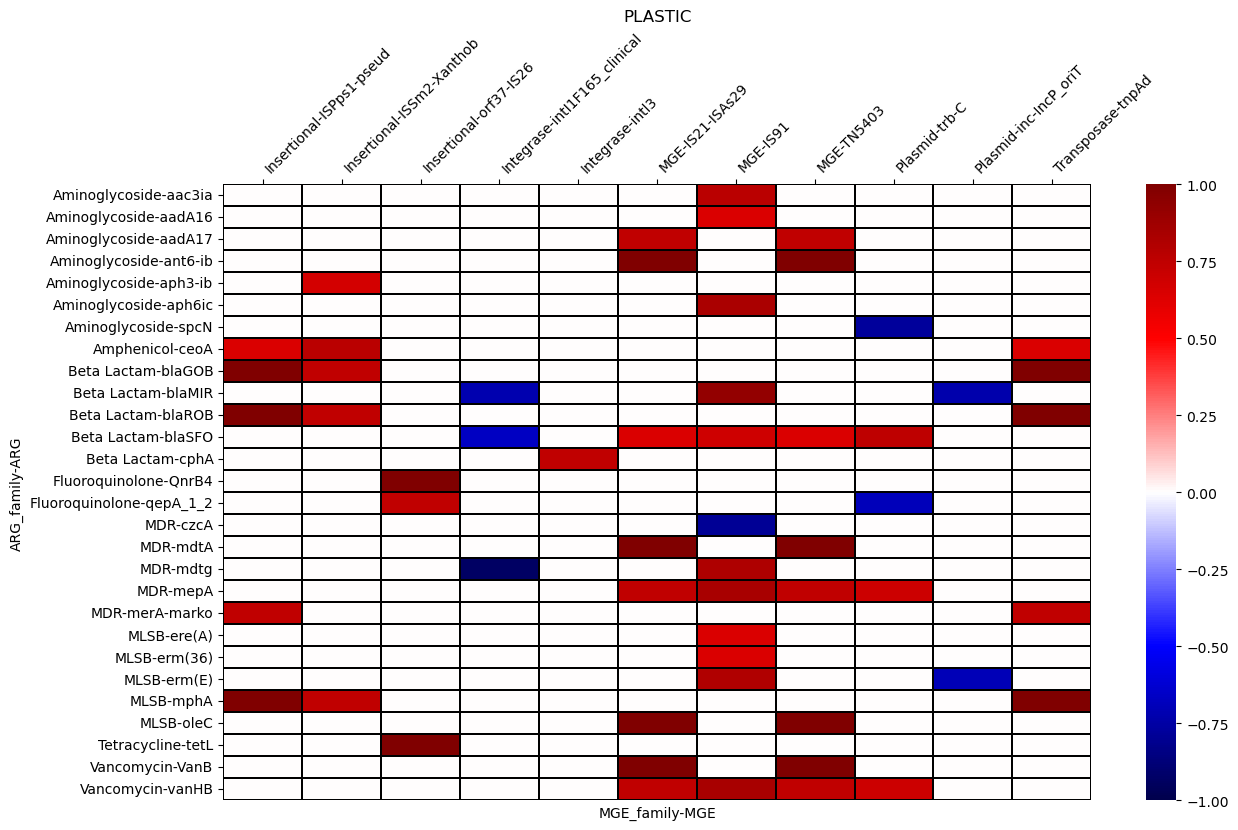

In [59]:
fig, ax = plt.subplots(figsize=(14,8))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("white") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(plastic_spear, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("PLASTIC")
ax.xaxis.tick_top()

#### CONTROL

In [30]:
corr_data = spearman_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "control")],
                            y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "control")],
                            merge_col_name = "sample",
                            groupby_name = "Assay",
                            test_col = "rel_ab",
                            threshold = 0,
                            p_val = 0.05
                           )
control_spear = dict_pivotizer(corr_data, copy = False,
                               id1_name = "MGE", id2_name = "ARG", val_name = "spearman_correlation",
                               id1_fam = "MGE_family", id2_fam = "ARG_family")
control_spear = control_spear.fillna(0)

/home/juanma/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


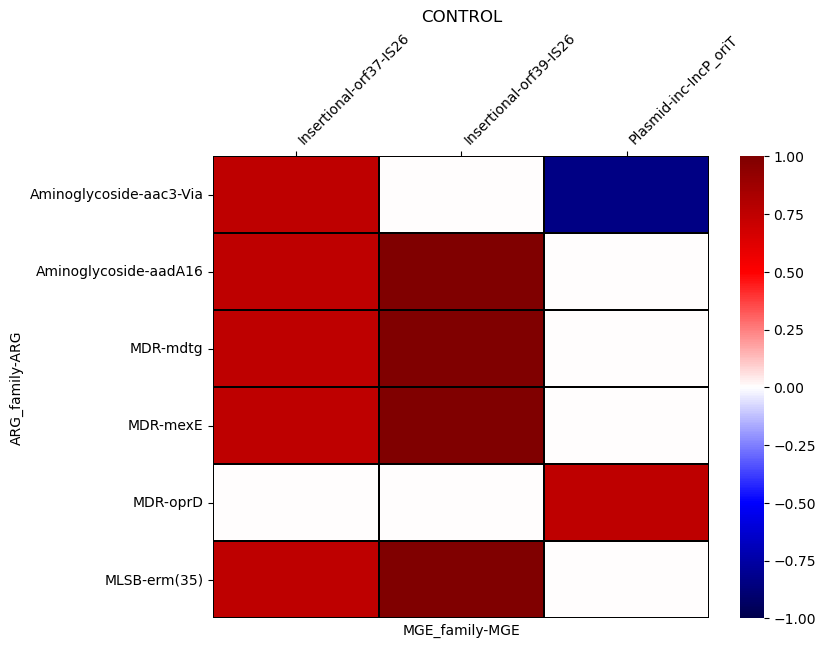

In [62]:

fig, ax = plt.subplots(figsize=(8,6))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("white") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(control_spear, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("CONTROL")
ax.xaxis.tick_top()

### CORRELACIÓN DE PEARSON

---

#### PLÁSTICO

In [32]:
def pearson_finder (x, y, merge_col_name = "sample", 
                     groupby_name = "Assay", test_col = "log_n",
                     p_val = 0.05, threshold = 0):
    
    # Lleva a cabo el merge original, el emparejamiento
    merged_df = pd.merge(x, y, on = merge_col_name)
    
    # Genera los nuevos nombres de variable
    group_x = groupby_name + "_x"
    group_y = groupby_name + "_y"
    test_x = test_col + "_x"
    test_y = test_col + "_y"
    
    #rng = np.random.default_rng()
    #method = stat.PermutationMethod(n_resamples=np.inf, random_state=rng)
    grouped_merge = merged_df.groupby([group_x, group_y]) #y empareja
    
    corr_dict ={}
    for name, group in grouped_merge:
        corr_res = stat.pearsonr(group[test_x], group[test_y])
        if (abs(corr_res[0]) >= threshold) and (corr_res[1] < p_val): corr_dict[name] = corr_res
    return corr_dict

In [33]:
corr_data = pearson_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "plastic")],
                            y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "plastic")],
                            merge_col_name = "sample",
                            groupby_name = "Assay",
                            test_col = "rel_ab",
                            threshold = 0,
                            p_val = 0.05
                           )
plastic_pear = dict_pivotizer(corr_data, copy = False,
                              id1_name = "MGE", id2_name = "ARG", val_name = "spearman_correlation",
                              id1_fam = "MGE_family", id2_fam = "ARG_family")
plastic_pear = plastic_pear.fillna(0)

/home/juanma/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


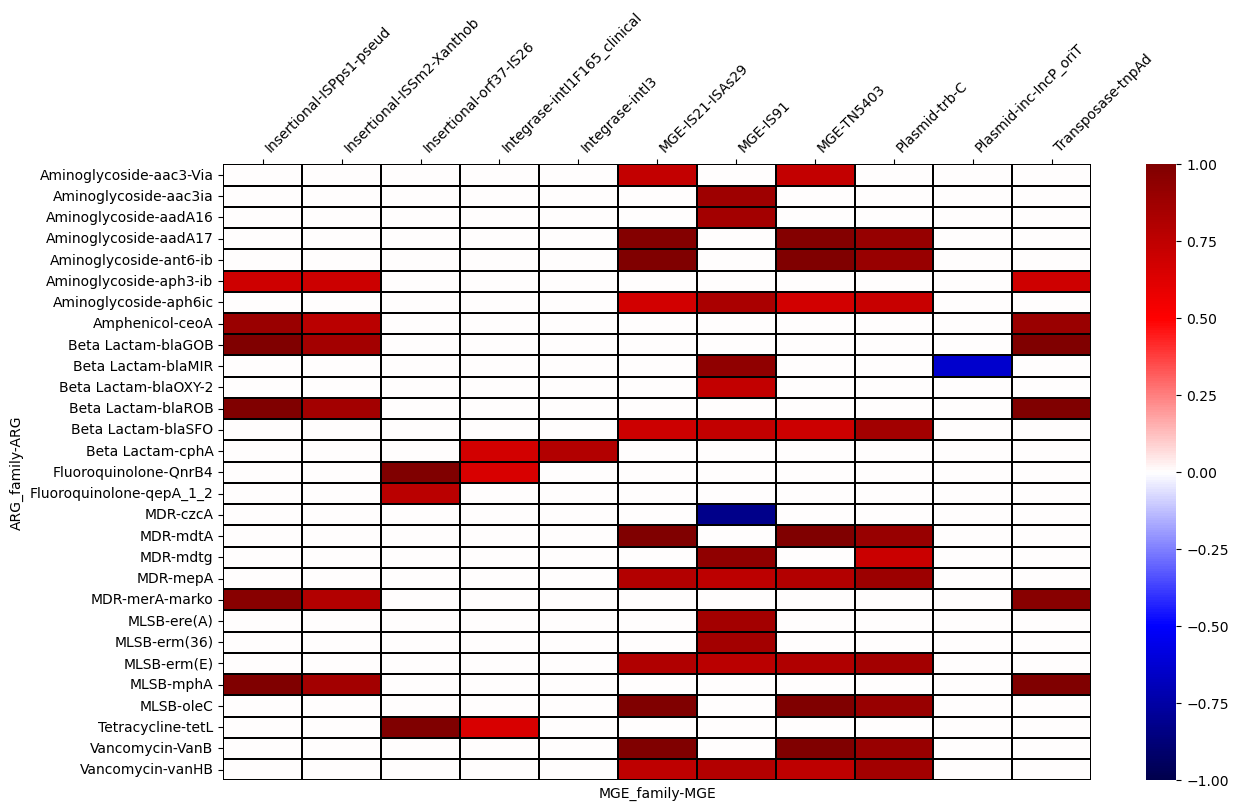

In [63]:
### ALTERNATIVA
fig, ax = plt.subplots(figsize=(14,8))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("white") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(plastic_pear, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.xaxis.tick_top()

#### CONTROL

In [35]:
corr_data = pearson_finder(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "control")],
                            y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "control")],
                            merge_col_name = "sample",
                            groupby_name = "Assay",
                            test_col = "rel_ab",
                            threshold = 0,
                            p_val = 0.05
                           )
control_pear = dict_pivotizer(corr_data, copy = False,
                              id1_name = "MGE", id2_name = "ARG", val_name = "spearman_correlation",
                              id1_fam = "MGE_family", id2_fam = "ARG_family")
control_pear = control_pear.fillna(0)

/home/juanma/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


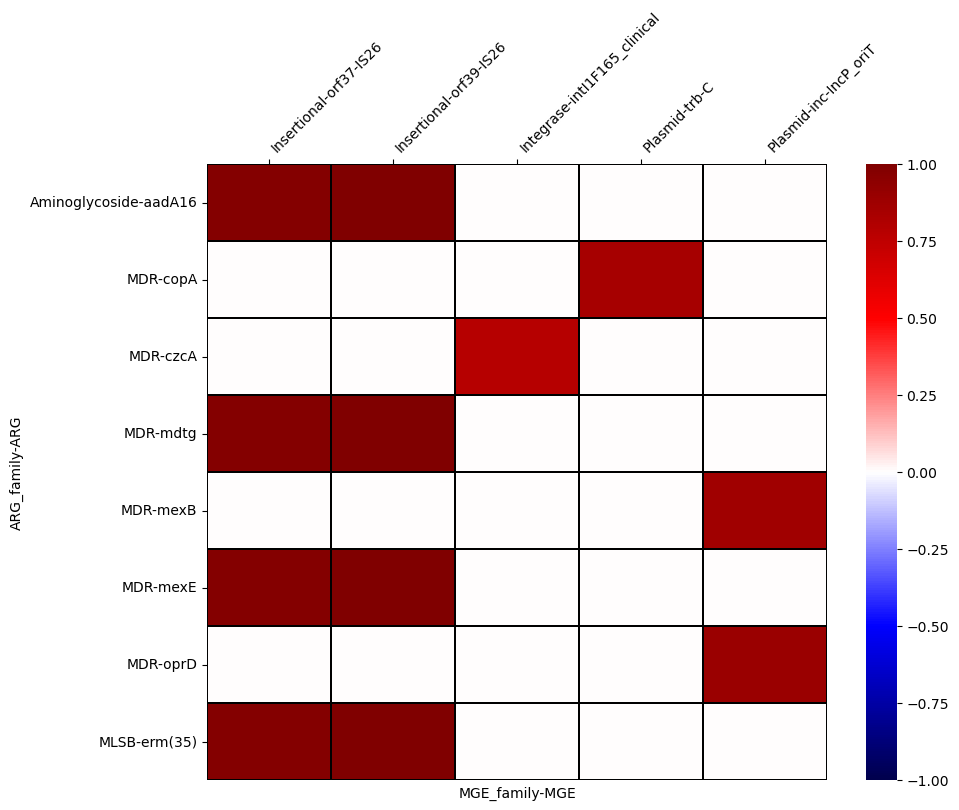

In [64]:
### ALTERNATIVA
fig, ax = plt.subplots(figsize=(10,8))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("white") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(control_pear, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.xaxis.tick_top()

### PEARSON CON P-VALOR EXACTO

Cuando calculo la correlación y obtengo su p-valor lo que estoy haciendo es comprobar cómo de probable es que el valor que he obtenido ESTA NOTA ESTÁ A MEDIAS LOL

In [77]:
def correlation_permuted (x, y, merge_col_name = "sample", 
                          groupby_name = "Assay", test_col = "log_n",
                          p_val = 0.05,
                          how = "pearson"
                         ):
    
    # Lleva a cabo el merge original, el emparejamiento
    x = x[[merge_col_name, groupby_name, test_col]]
    y = y[[merge_col_name, groupby_name, test_col]]
    
    merged_df = pd.merge(x, y, on = merge_col_name)
    
    # Genera los nuevos nombres de variable
    group_x = groupby_name + "_x"
    group_y = groupby_name + "_y"
    test_x = test_col + "_x"
    test_y = test_col + "_y"
    
    grouped_merge = merged_df.groupby([group_x, group_y]) #y empareja
    
    #Variables útiles para el pearson
    rng = np.random.default_rng()
    method = stat.PermutationMethod(n_resamples=9999, random_state=rng)
    
    corr_dict ={} #llevar la cuenta de resultados
    count = 0 # llevar la cuenta del nº de loops, útil para hacer pruebas
    current_mge = "" #guarda el nombre del mge actual, útil para saber cuándo ha cambiado el mge
    #result_file = open("../data/clean_data/pearson_permuted.txt", mode = "a") #crea el archivo la primera vez, lo actualiza el resto
    
    
    for name, group in grouped_merge:
        if (name[0] != current_mge):
            print (" ########## Now working on MGE:", name[0], " ##########") #anuncio el cambio
        current_mge = name[0]
        if how == "pearson":
            corr_res = stat.pearsonr(group[test_x], group[test_y], method = method)
        else: 
            corr_res = stat.spearmanr(group[test_x], group[test_y], method = method, nan_policy = "omit")
        if corr_res[1] < p_val: 
            corr_dict[name] = corr_res
            print ("### correlation found!:", name[1], "###")
        count += 1
        #corr_dict[name] = corr_res
        if count > 11:
            print("12 done!")
            count = 0
    return corr_dict

#### PLÁSTICO

In [78]:
corr_data = correlation_permuted(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "plastic")],
                                 y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "plastic")],
                                 merge_col_name = "sample",
                                 groupby_name = "Assay",
                                 test_col = "rel_ab",
                                 p_val = 0.05,
                                 how = "pearson"
                                )
plastic_pearmuted = dict_pivotizer(corr_data, copy = True,
                              id1_name = "MGE", id2_name = "ARG", val_name = "pearson_correlation",
                              id1_fam = "MGE_family", id2_fam = "ARG_family")

 ########## Now working on MGE: IS21-ISAs29  ##########
12 done!
12 done!


/home/juanma/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


12 done!
12 done!
 ########## Now working on MGE: IS91  ##########
### correlation found!: aac3ia ###
12 done!
### correlation found!: aph6ic ###
### correlation found!: blaMIR ###
12 done!
### correlation found!: czcA ###
### correlation found!: erm(E) ###
### correlation found!: mdtg ###
12 done!
### correlation found!: tetPA ###
12 done!
 ########## Now working on MGE: ISPps1-pseud  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: ISSm2-Xanthob  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: IncP_oriT  ##########
12 done!
### correlation found!: blaMIR ###
12 done!
### correlation found!: erm(E) ###
12 done!
12 done!
 ########## Now working on MGE: TN5403  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: fabK  ##########
### correlation found!: aac3ia ###
### correlation found!: aadA7 ###
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: intI1F165_clinical  ##########
12 don

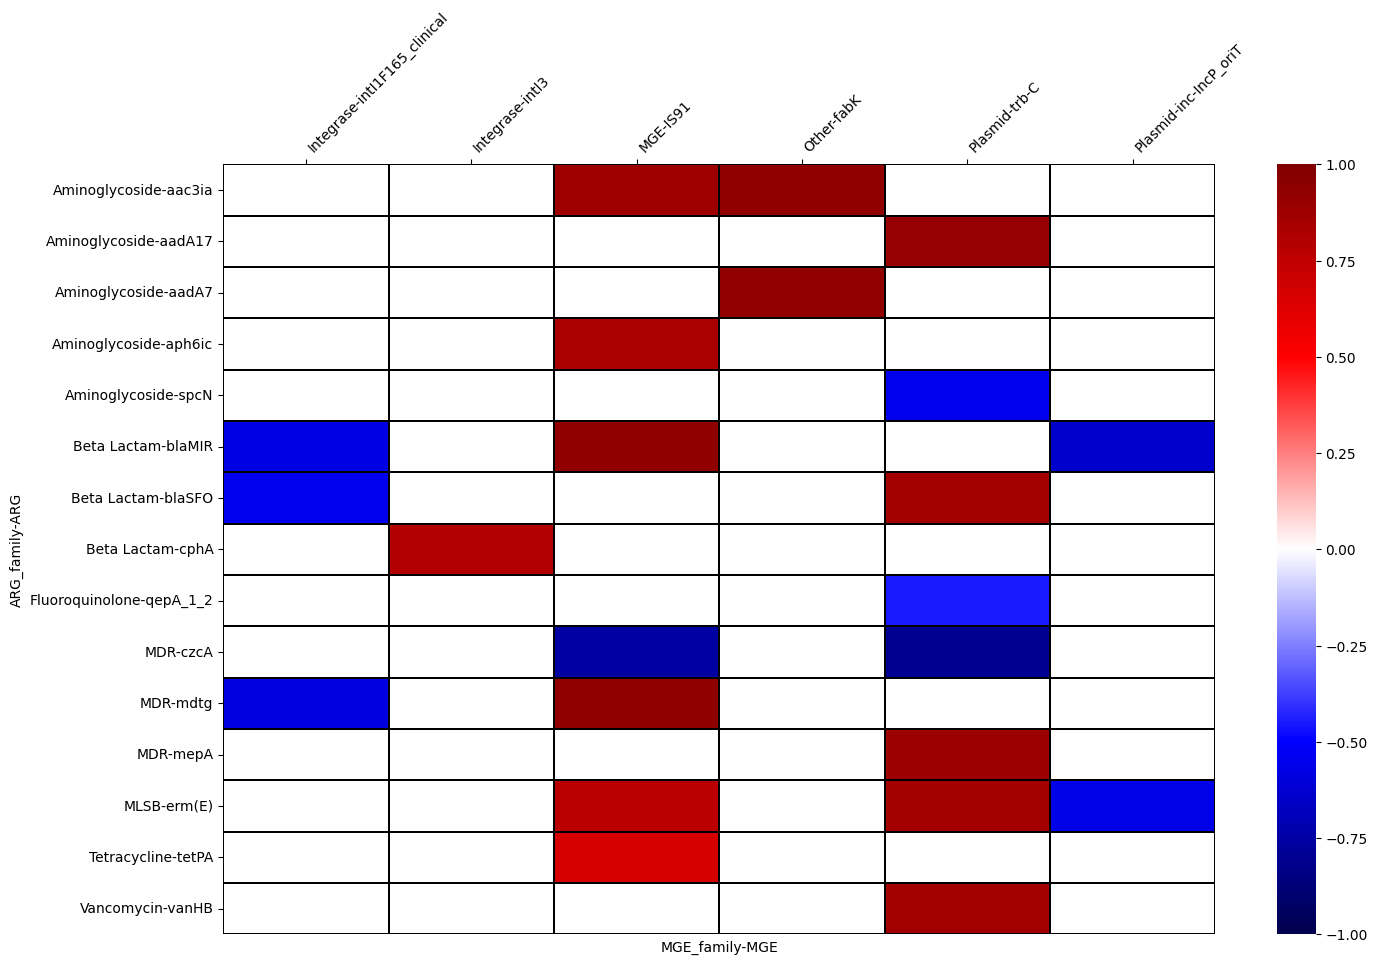

In [79]:
fig, ax = plt.subplots(figsize=(16,10))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("white") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(plastic_pearmuted, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.xaxis.tick_top()

#### CONTROL

In [74]:
## Y ahora el control
#orr_data = correlation_permuted(x = work_data.loc[(work_data["or_seq"] == "mge") & (work_data["type_g"] == "control")],
                                 y = work_data.loc[(work_data["or_seq"] == "arg") & (work_data["type_g"] == "control")],
                                 merge_col_name = "sample",
                                 groupby_name = "Assay",
                                 test_col = "rel_ab",
                                 p_val = 0.05,
                                 how = "pearson"
                                )
control_pearmuted = dict_pivotizer(corr_data, copy = True,
                              id1_name = "MGE", id2_name = "ARG", val_name = "pearson_correlation",
                              id1_fam = "MGE_family", id2_fam = "ARG_family")

 ########## Now working on MGE: IS21-ISAs29  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: IS91  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: ISPps1-pseud  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: ISSm2-Xanthob  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: IncP_oriT  ##########


/home/juanma/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


### correlation found!: aac3-Via ###
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: TN5403  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: fabK  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: intI1F165_clinical  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: intl3  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: orf37-IS26  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: orf39-IS26  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: tnpAd  ##########
12 done!
12 done!
12 done!
12 done!
 ########## Now working on MGE: trb-C  ##########
12 done!
12 done!
12 done!
12 done!
Copying! REMEMBER TO CHANGE THE NAME!!


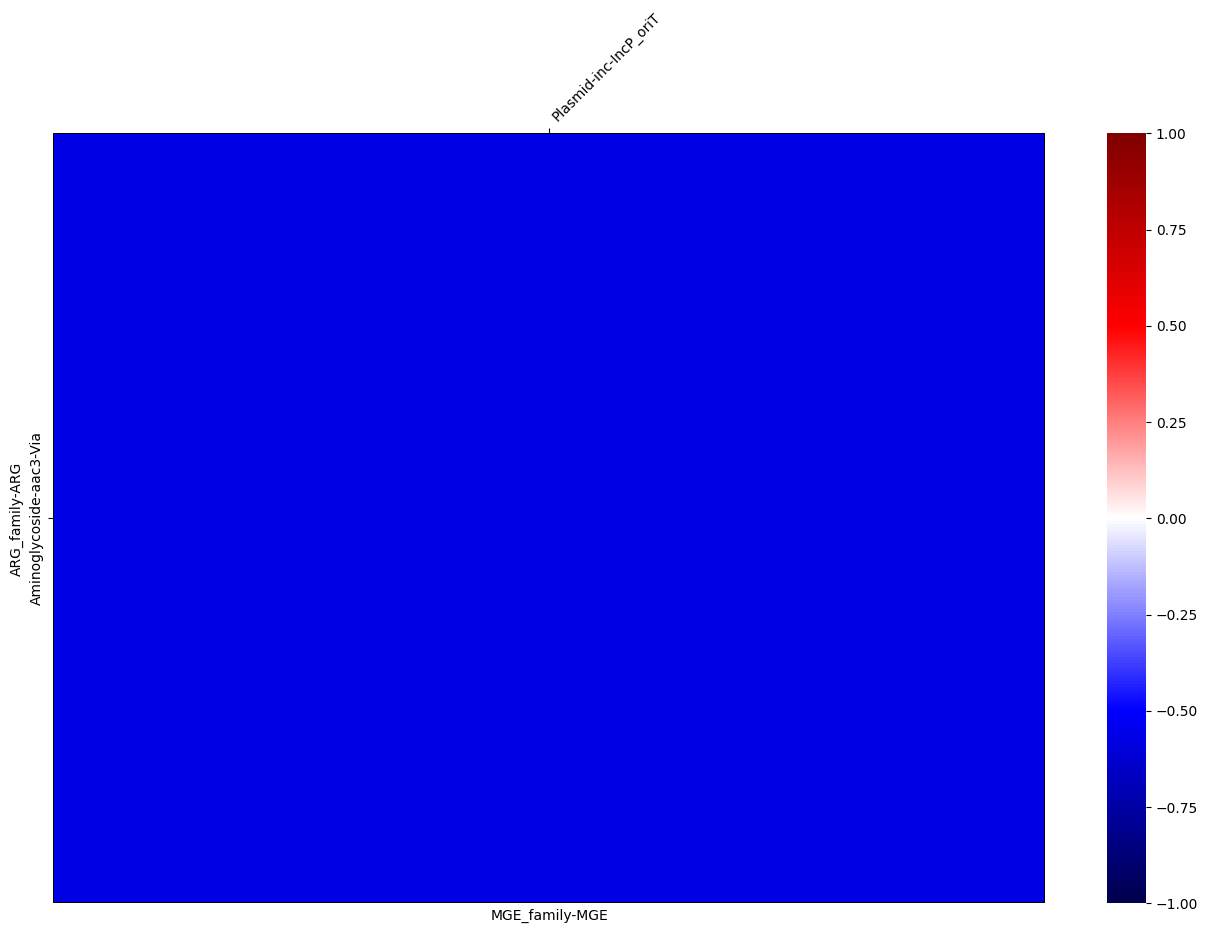

In [76]:
control_pearmuted = plastic_pearmuted
fig, ax = plt.subplots(figsize=(16,10))
red_cmap = mpl.colormaps["seismic"]
red_cmap.set_under("white") #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(control_pearmuted, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.xaxis.tick_top()

## COMPARATIVA ESTADÍSTICOS VS DESCRIPTIVOS

Me interesa encontrar alguna manera de comparar la gráfica de correlación de spearman permutada (o la normal en sí) con la gráfica de correlación por presencia. Creo que lo primero va a ser estudiar los máximos y los mínimos de las correlaciones estadísticas, pues probablemente por tener que estar por debajo de determinados umbrales muchas de las diferencias se deban a valores bajos

In [37]:
abs(plastic_spear.min())

MGE_family   MGE               
Insertional  ISPps1-pseud          0.000000
             ISSm2-Xanthob         0.000000
             orf37-IS26            0.000000
Integrase    intI1F165_clinical    0.935424
             intl3                 0.000000
MGE          IS21-ISAs29           0.000000
             IS91                  0.792617
             TN5403                0.000000
Plasmid      trb-C                 0.773900
Plasmid-inc  IncP_oriT             0.728357
Transposase  tnpAd                 0.000000
dtype: float64

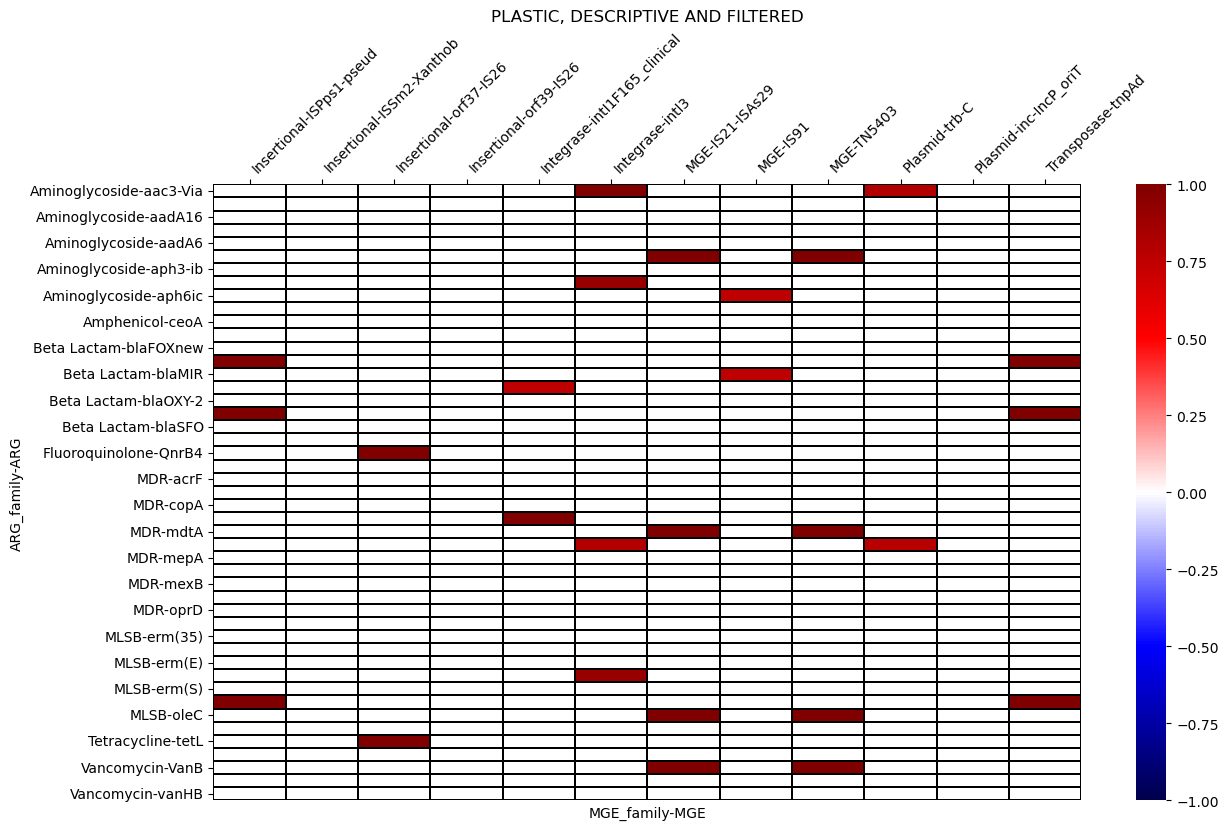

In [65]:
filtered_plastic = plastic_pivot[plastic_pivot > 0.72]
fig, ax = plt.subplots(figsize=(14,8))
red_cmap = mpl.colormaps["seismic"]
#red_cmap.set_under("white", alpha = 0.4) #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(filtered_plastic, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("PLASTIC, DESCRIPTIVE AND FILTERED")
ax.xaxis.tick_top()


Se me ocurre que, dado que no puedo restar los df y punto por el efecto que tendrían los valores negativos, lo siguiente mejor es representarlos lado a lado. Que en este caso, dado el tamaño de los heatmaps, es inviable más allá de pestaña a pestaña.

Para ello, lo primero es que ambos df compartan los mismos ejes, aunque ello suponga que aumente el nº de casillas en blanco

In [44]:
# Como el df de codetección es el de mayores dimensiones, voy a representar los valores de spearman normal en sus ejes. Para hacerme con sus ejes,
# los vacío (igualo todos sus datos a 0) y le sumo el df de interés 
plastic_empty = plastic_pivot.copy(deep = True)

for col in plastic_empty.columns:
    plastic_empty[col].values[:] = 0
plastic_empty.tail()

MGE_family          Insertional                                      \
MGE                ISPps1-pseud ISSm2-Xanthob orf37-IS26 orf39-IS26   
ARG_family   ARG                                                      
Tetracycline tetL           0.0           0.0        0.0        0.0   
             tetPA          0.0           0.0        0.0        0.0   
Vancomycin   VanB           0.0           0.0        0.0        0.0   
             vanA           0.0           0.0        0.0        0.0   
             vanHB          0.0           0.0        0.0        0.0   

MGE_family                  Integrase               MGE             Plasmid  \
MGE                intI1F165_clinical intl3 IS21-ISAs29 IS91 TN5403   trb-C   
ARG_family   ARG                                                              
Tetracycline tetL                 0.0   0.0         0.0  0.0    0.0     0.0   
             tetPA                0.0   0.0         0.0  0.0    0.0     0.0   
Vancomycin   VanB                 0.0   0.0         0.0  0.0    0.0     0.0   
             vanA                 0.0   0.0         0.0  0.0    0.0     0.0   
             vanHB                0.0   0.0         0.0  0.0    0.0     0.0   

MGE_family         Plasmid-inc Transposase  
MGE                  IncP_oriT       tnpAd  
ARG_family   ARG                            
Tetracycline tetL          0.0         0.0  
             tetPA         0.0         0.0  
Vancomycin   VanB          0.0         0.0  
             vanA          0.0         0.0  
             vanHB         0.0         0.0

In [48]:
big_plastic_spear = plastic_empty + plastic_spear
if big_plastic_spear.shape == plastic_empty.shape: print("¡Chachi!") #chequeo rápido

¡Chachi!


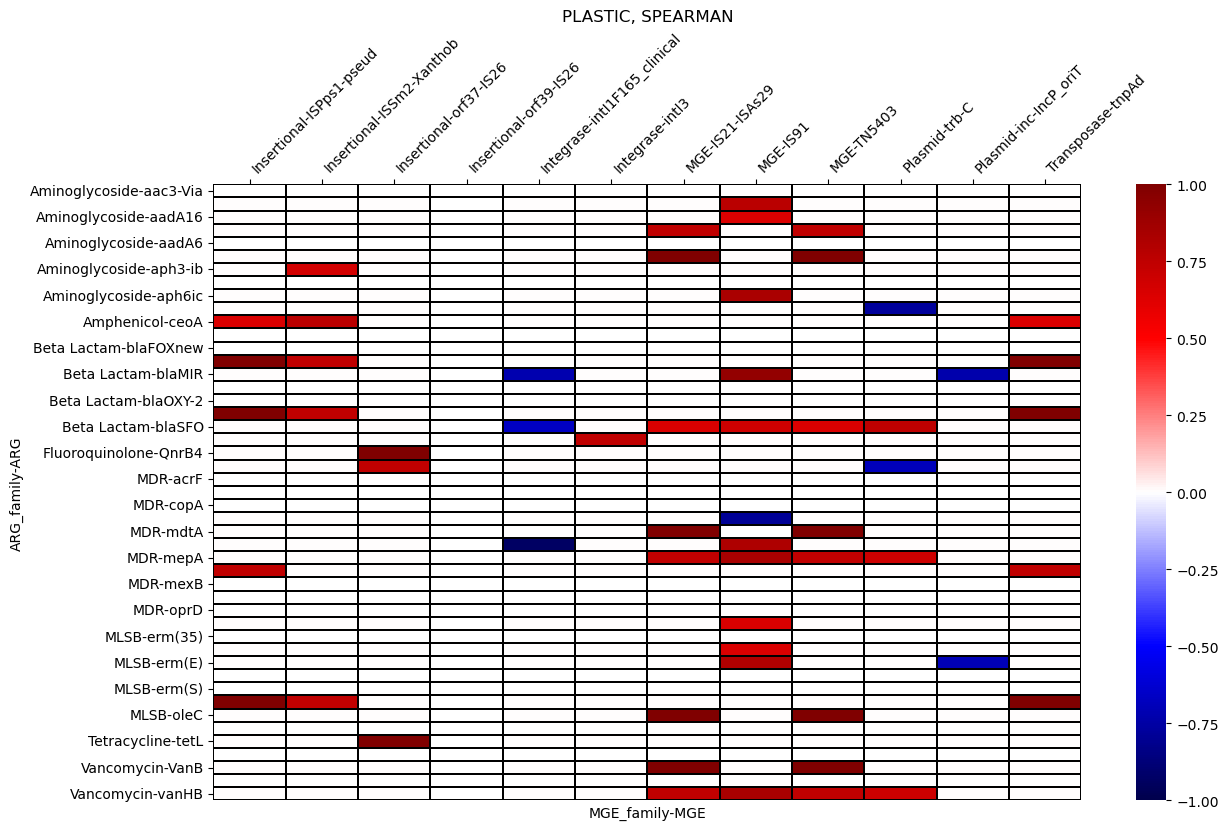

In [53]:
fig, ax = plt.subplots(figsize=(14,8))
red_cmap = mpl.colormaps["seismic"]
#red_cmap.set_under("white", alpha = 0.4) #76FF7B = pistacho #7FFF00 = verde pero feísimo, parece licor de hierbas

lala = sns.heatmap(big_plastic_spear, 
                   cmap = red_cmap,
                   vmax = 1, vmin = -1,
                   linecolor = "black",
                   linewidths = 0.01, robust = True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = "left")
ax.set_title("PLASTIC, SPEARMAN")
ax.xaxis.tick_top()


Como se puede observar, si nos quedamos sólamente con aquellos que entren dentro del rango de valores y comparamos, los resultados son iguales, casi que con mayor nº de detecciones vía spearman. Ahora bien, sigue habiendo unas cuantas que coinciden siempre pero no tienen ninguna correlación. Me interesa graficarlas para ver qué sucede con ellas

In [93]:
# primero me quedo sólo con los 100%
filtered_plastic_top = filtered_plastic[filtered_plastic == 1]
plastic_spear_top = big_plastic_spear[big_plastic_spear > 0.9] #no confío en que haya correlaciones del 100% estadísticas asi que me curo de espanto


# Ahora resto
filtered_plastic_top = filtered_plastic_top.fillna(0) #necesario para poder restar
plastic_spear_top = plastic_spear_top.fillna(0) 
diffs = filtered_plastic_top - plastic_spear_top #sólo van a seguir siendo 1 aquellos con una loca diferencia
diffs = diffs[(diffs.isin([1]))]
diffs.dropna(how = "all", inplace = True)
diffs

MGE_family               Insertional                                      \
MGE                     ISPps1-pseud ISSm2-Xanthob orf37-IS26 orf39-IS26   
ARG_family     ARG                                                         
Aminoglycoside aac3-Via          NaN           NaN        NaN        NaN   
MDR            czcA              NaN           NaN        NaN        NaN   

MGE_family                       Integrase               MGE              \
MGE                     intI1F165_clinical intl3 IS21-ISAs29 IS91 TN5403   
ARG_family     ARG                                                         
Aminoglycoside aac3-Via                NaN   1.0         NaN  NaN    NaN   
MDR            czcA                    1.0   NaN         NaN  NaN    NaN   

MGE_family              Plasmid Plasmid-inc Transposase  
MGE                       trb-C   IncP_oriT       tnpAd  
ARG_family     ARG                                       
Aminoglycoside aac3-Via     NaN         NaN         NaN  
MDR            czcA         NaN         NaN         NaN

Es una manera bastante chapucera de hacerlo, pero ahora sé que hay que comprobar:
- aac3-Via vs intl3
- czcA vs intI1F165_clinical

In [119]:
#voy a sacar los datos. ¡RECUERDA QUE ESTO ES SÓLO EN PLÁSTICOS!
aac3_data = work_data.loc[(work_data["Assay"] == "aac3-Via") & (work_data["type_g"] == "plastic")]
intl3_data = work_data.loc[(work_data["Assay"] == "intl3") & (work_data["type_g"] == "plastic")]
czcA_data = work_data.loc[(work_data["Assay"] == "czcA") & (work_data["type_g"] == "plastic")]
intI1F_data = work_data.loc[(work_data["Assay"] == "intI1F165_clinical") & (work_data["type_g"] == "plastic")] #ojo que este nombre lo escribieron mal los franceses lolísimos
#print(aac3_data["sample"])
#print(intl3_data["sample"])


8      17.0
67     18.0
126     7.0
185     8.0
244     9.0
362    15.0
421    10.0
480    12.0
539    16.0
952    11.0
Name: sample, dtype: float64
50     17.0
109    18.0
168     7.0
227     8.0
286     9.0
404    15.0
463    10.0
522    12.0
581    16.0
994    11.0
Name: sample, dtype: float64


/home/juanma/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juanma/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='aac3', ylabel='intl3'>

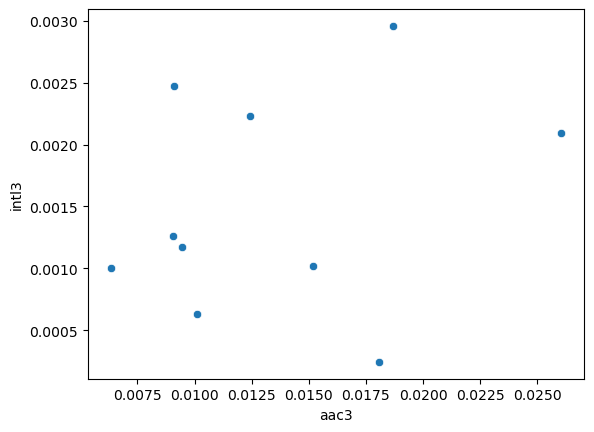

In [126]:
paired = pd.merge(aac3_data, intl3_data, on = "sample")
paired = paired.rename(columns = {"rel_ab_x": "aac3", "rel_ab_y": "intl3"})
paired = paired[["sample", "aac3", "intl3"]]

sns.scatterplot(data=paired, x="aac3", y="intl3")

/home/juanma/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juanma/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='czcA', ylabel='int'>

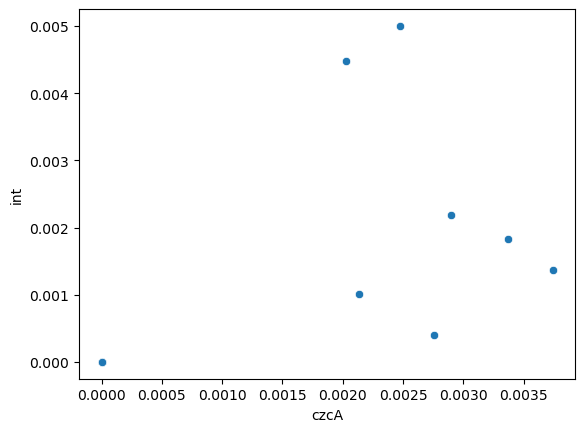

In [127]:
paired = pd.merge(czcA_data, intI1F_data, on = "sample")
paired = paired.rename(columns = {"rel_ab_x": "czcA", "rel_ab_y": "int"})
paired = paired[["sample", "czcA", "int"]]

sns.scatterplot(data=paired, x="czcA", y="int")